In [1]:
import os
from collections import Counter
from functools import reduce
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import gmplot
from IPython.display import IFrame
import tensorflow as tf
import math
import re

<h5>Baseline data has no na values</h5>

In [190]:
print(bsln_trn.isna().sum())
print(bsln_trn.isnull().sum())

collectionName                0
phoneName                     0
millisSinceGpsEpoch           0
latDeg                        0
lngDeg                        0
heightAboveWgs84EllipsoidM    0
phone                         0
dtype: int64
collectionName                0
phoneName                     0
millisSinceGpsEpoch           0
latDeg                        0
lngDeg                        0
heightAboveWgs84EllipsoidM    0
phone                         0
dtype: int64


In [152]:
bsln_trn.value_counts()

collectionName       phoneName        millisSinceGpsEpoch  latDeg     lngDeg       heightAboveWgs84EllipsoidM  phone                              
2021-04-29-US-SJC-2  SamsungS20Ultra  1303760319000        37.334485  -121.899570  -7.64                       2021-04-29-US-SJC-2_SamsungS20Ultra    1
2020-07-08-US-MTV-1  Pixel4XLModded   1278283189448        37.451172  -122.125234  -34.33                      2020-07-08-US-MTV-1_Pixel4XLModded     1
                                      1278283095448        37.431540  -122.104583  -27.91                      2020-07-08-US-MTV-1_Pixel4XLModded     1
                                      1278283096448        37.431724  -122.104786  -29.85                      2020-07-08-US-MTV-1_Pixel4XLModded     1
                                      1278283097448        37.431922  -122.104998  -28.60                      2020-07-08-US-MTV-1_Pixel4XLModded     1
                                                                                             

In [156]:
bsln_trn_indexed = bsln_trn.set_index(['phone', 'millisSinceGpsEpoch'])
bsln_trn_indexed.value_counts()

collectionName       phoneName  latDeg     lngDeg       heightAboveWgs84EllipsoidM
2020-05-29-US-MTV-2  Pixel4XL   37.416390  -122.078071  -26.83                        65
                     Pixel4     37.416394  -122.078060  -26.94                        64
2020-06-05-US-MTV-2  Pixel4XL   37.624707  -122.428272   27.13                         5
2020-09-04-US-SF-2   Pixel4XL   37.624732  -122.428261   24.54                         5
2020-06-04-US-MTV-1  Pixel4XL   37.633220  -122.419402  -21.45                         3
                                                                                      ..
2021-01-05-US-SVL-1  Pixel4XL   37.352227  -122.061199   27.60                         1
                                37.352231  -122.061220   38.56                         1
                                           -122.060171   27.39                         1
                                37.352236  -122.061217   33.93                         1
2020-05-14-US-MTV-1  Pixel4

In [11]:
df = pd.read_csv('google-smartphone-decimeter-challenge/train/2020-05-14-US-MTV-1/Pixel4/Pixel4_derived.csv')
derived = df.drop(0)
df = pd.read_csv('google-smartphone-decimeter-challenge/train/2020-05-14-US-MTV-1/Pixel4/ground_truth.csv')
ground = df.drop(0)
bsln_trn = pd.read_csv('google-smartphone-decimeter-challenge/baseline_locations_train.csv')
bsln_tst = pd.read_csv('google-smartphone-decimeter-challenge/baseline_locations_test.csv')
target = ground.merge(bsln_trn, how='inner', on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], suffixes=('_grnd', '_bsln'))
target['latDiff'] = target['latDeg_grnd']-target['latDeg_bsln']
target['lngDiff'] = target['lngDeg_grnd']-target['lngDeg_bsln']
target['latlngDiff'] = abs(target['latDiff'] + target['lngDiff'])

In [19]:
derived.columns, ground.columns

(Index(['collectionName', 'phoneName', 'millisSinceGpsEpoch',
        'constellationType', 'svid', 'signalType', 'receivedSvTimeInGpsNanos',
        'xSatPosM', 'ySatPosM', 'zSatPosM', 'xSatVelMps', 'ySatVelMps',
        'zSatVelMps', 'satClkBiasM', 'satClkDriftMps', 'rawPrM', 'rawPrUncM',
        'isrbM', 'ionoDelayM', 'tropoDelayM'],
       dtype='object'),
 Index(['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg',
        'lngDeg', 'heightAboveWgs84EllipsoidM', 'timeSinceFirstFixSeconds',
        'hDop', 'vDop', 'speedMps', 'courseDegree'],
       dtype='object'))

In [18]:
derived.merge(ground, how='inner', on=['phoneName', 'collectionName', 'millisSinceGpsEpoch'], suffixes=('_grnd', 'bsln')).columns

Index(['collectionName', 'phoneName', 'millisSinceGpsEpoch',
       'constellationType', 'svid', 'signalType', 'receivedSvTimeInGpsNanos',
       'xSatPosM', 'ySatPosM', 'zSatPosM', 'xSatVelMps', 'ySatVelMps',
       'zSatVelMps', 'satClkBiasM', 'satClkDriftMps', 'rawPrM', 'rawPrUncM',
       'isrbM', 'ionoDelayM', 'tropoDelayM', 'latDeg', 'lngDeg',
       'heightAboveWgs84EllipsoidM', 'timeSinceFirstFixSeconds', 'hDop',
       'vDop', 'speedMps', 'courseDegree'],
      dtype='object')

In [30]:
derived['millisSinceGpsEpoch_drvd'] = derived['millisSinceGpsEpoch']
derived_idx = derived.set_index(['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'svid'])

In [31]:
drv_bsln = derived.merge(bsln_trn, how='inner', on=['phoneName', 'collectionName', 'millisSinceGpsEpoch'], suffixes=('_drvd', 'bsln'))

In [32]:
drv_bsln.columns

Index(['collectionName', 'phoneName', 'millisSinceGpsEpoch',
       'constellationType', 'svid', 'signalType', 'receivedSvTimeInGpsNanos',
       'xSatPosM', 'ySatPosM', 'zSatPosM', 'xSatVelMps', 'ySatVelMps',
       'zSatVelMps', 'satClkBiasM', 'satClkDriftMps', 'rawPrM', 'rawPrUncM',
       'isrbM', 'ionoDelayM', 'tropoDelayM', 'correctedPrM',
       'millisSinceGpsEpoch_drvd', 'latDeg', 'lngDeg',
       'heightAboveWgs84EllipsoidM', 'phone'],
      dtype='object')

In [24]:
derived['correctedPrM'] = derived['rawPrM'] + derived['satClkBiasM'] - derived['isrbM'] - derived['ionoDelayM'] -derived['tropoDelayM']

In [59]:
corrected_piv_svid = derived.pivot_table(values=['correctedPrM'], index=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], columns=['svid'])
corrected_piv_svid

correctedPrM                \
svid                                                         1             2    
collectionName      phoneName millisSinceGpsEpoch                               
2020-05-14-US-MTV-1 Pixel4    1273529464442        2.507294e+07  2.089991e+07   
                              1273529465442        2.507256e+07  2.090013e+07   
                              1273529466442        2.507216e+07  2.090035e+07   
                              1273529467442        2.507177e+07  2.090058e+07   
                              1273529468442        2.507138e+07  2.090080e+07   
...                                                         ...           ...   
                              1273531198442        2.445723e+07  2.139547e+07   
                              1273531199442        2.445694e+07  2.139580e+07   
                              1273531200442        2.445666e+07  2.139615e+07   
                              1273531201442        2.445638e+07  2.139649e+07   
                              1273531202442        2.445581e+07           NaN   

                                                                               \
svid                                                         5             6    
collectionName      phoneName millisSinceGpsEpoch                               
2020-05-14-US-MTV-1 Pixel4    1273529464442        2.304851e+07  2.224639e+07   
                              1273529465442        2.304792e+07  2.224692e+07   
                              1273529466442        2.304734e+07  2.224744e+07   
                              1273529467442        2.304676e+07  2.224798e+07   
                              1273529468442        2.304616e+07  2.224850e+07   
...                                                         ...           ...   
                              1273531198442        2.214838e+07  2.335151e+07   
                              1273531199442        2.214790e+07  2.335194e+07   
                              1273531200442        2.214742e+07  2.335238e+07   
                              1273531201442        2.214694e+07  2.335280e+07   
                              1273531202442        2.214598e+07  2.335367e+07   

                                                                               \
svid                                                         7             8    
collectionName      phoneName millisSinceGpsEpoch                               
2020-05-14-US-MTV-1 Pixel4    1273529464442                 NaN           NaN   
                              1273529465442                 NaN           NaN   
                              1273529466442                 NaN           NaN   
                              1273529467442                 NaN           NaN   
                              1273529468442                 NaN           NaN   
...                                                         ...           ...   
                              1273531198442        2.309451e+07           NaN   
                              1273531199442        2.309406e+07           NaN   
                              1273531200442        2.309363e+07  2.431683e+07   
                              1273531201442        2.309318e+07  2.431616e+07   
                              1273531202442        2.309230e+07  2.431481e+07   

                                                                               \
svid                                                         11            12   
collectionName      phoneName millisSinceGpsEpoch                               
2020-05-14-US-MTV-1 Pixel4    1273529464442        2.275315e+07  1.987075e+07   
                              1273529465442        2.275395e+07  1.987088e+07   
                              1273529466442        2.275478e+07  1.987101e+07   
                              1273529467442        2.275558e+07  1.987113e+07   
                              1273529468442        2.275640e+07  1.987126e+07  

In [35]:
max_time = derived[['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'millisSinceGpsEpoch_drvd', 'receivedSvTimeInGpsNanos']].groupby(['collectionName', 'phoneName', 'millisSinceGpsEpoch']).max()

In [54]:
# corrected_piv_svid_no_idx = corrected_piv_svid.reset_index(inplace=False)
# corrected_piv_svid_no_idx
corrected_piv_svid_flat_idx = corrected_piv_svid
corrected_piv_svid_flat_idx.columns = corrected_piv_svid.columns.to_flat_index()
corrected_piv_svid_flat_idx

(correctedPrM, 1)  \
collectionName      phoneName millisSinceGpsEpoch                      
2020-05-14-US-MTV-1 Pixel4    1273529464442             2.507294e+07   
                              1273529465442             2.507256e+07   
                              1273529466442             2.507216e+07   
                              1273529467442             2.507177e+07   
                              1273529468442             2.507138e+07   
...                                                              ...   
                              1273531198442             2.445723e+07   
                              1273531199442             2.445694e+07   
                              1273531200442             2.445666e+07   
                              1273531201442             2.445638e+07   
                              1273531202442             2.445581e+07   

                                                   (correctedPrM, 2)  \
collectionName      phoneName millisSinceGpsEpoch                      
2020-05-14-US-MTV-1 Pixel4    1273529464442             2.089991e+07   
                              1273529465442             2.090013e+07   
                              1273529466442             2.090035e+07   
                              1273529467442             2.090058e+07   
                              1273529468442             2.090080e+07   
...                                                              ...   
                              1273531198442             2.139547e+07   
                              1273531199442             2.139580e+07   
                              1273531200442             2.139615e+07   
                              1273531201442             2.139649e+07   
                              1273531202442                      NaN   

                                                   (correctedPrM, 5)  \
collectionName      phoneName millisSinceGpsEpoch                      
2020-05-14-US-MTV-1 Pixel4    1273529464442             2.304851e+07   
                              1273529465442             2.304792e+07   
                              1273529466442             2.304734e+07   
                              1273529467442             2.304676e+07   
                              1273529468442             2.304616e+07   
...                                                              ...   
                              1273531198442             2.214838e+07   
                              1273531199442             2.214790e+07   
                              1273531200442             2.214742e+07   
                              1273531201442             2.214694e+07   
                              1273531202442             2.214598e+07   

                                                   (correctedPrM, 6)  \
collectionName      phoneName millisSinceGpsEpoch                      
2020-05-14-US-MTV-1 Pixel4    1273529464442             2.224639e+07   
                              1273529465442             2.224692e+07   
                              1273529466442             2.224744e+07   
                              1273529467442             2.224798e+07   
                              1273529468442             2.224850e+07   
...                                                              ...   
                              1273531198442             2.335151e+07   
                              1273531199442             2.335194e+07   
                              1273531200442             2.335238e+07   
                              1273531201442             2.335280e+07   
                              1273531202442             2.335367e+07   

                                                   (correctedPrM, 7)  \
collectionName      phoneName millisSinceGpsEpoch                      
2020-05-14-US-MTV-1 Pixel4    1273529464442                      NaN   
                              1273529465442                      NaN   
               

In [53]:
max_time

millisSinceGpsEpoch_drvd  \
collectionName      phoneName millisSinceGpsEpoch                             
2020-05-14-US-MTV-1 Pixel4    1273529464442                   1273529464442   
                              1273529465442                   1273529465442   
                              1273529466442                   1273529466442   
                              1273529467442                   1273529467442   
                              1273529468442                   1273529468442   
...                                                                     ...   
                              1273531198442                   1273531198442   
                              1273531199442                   1273531199442   
                              1273531200442                   1273531200442   
                              1273531201442                   1273531201442   
                              1273531202442                   1273531202442   

                                                   receivedSvTimeInGpsNanos  
collectionName      phoneName millisSinceGpsEpoch                            
2020-05-14-US-MTV-1 Pixel4    1273529464442             1273529463377208026  
                              1273529465442             1273529464377206858  
                              1273529466442             1273529465377205679  
                              1273529467442             1273529466377204477  
                              1273529468442             1273529467377203334  
...                                                                     ...  
                              1273531198442             1273531197376124258  
                              1273531199442             1273531198376124900  
                              1273531200442             1273531199376125497  
                              1273531201442             1273531200376126127  
                              1273531202442             1273531202376127322  

[1739 rows x 2 columns]

In [62]:
#crctd_piv_svid_on_max_time = corrected_piv_svid.merge(max_time, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'])
crctd_piv_svid_on_max_time = corrected_piv_svid_flat_idx.merge(max_time, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'])
crctd_piv_svid_on_max_time

(correctedPrM, 1)  \
collectionName      phoneName millisSinceGpsEpoch                      
2020-05-14-US-MTV-1 Pixel4    1273529464442             2.507294e+07   
                              1273529465442             2.507256e+07   
                              1273529466442             2.507216e+07   
                              1273529467442             2.507177e+07   
                              1273529468442             2.507138e+07   
...                                                              ...   
                              1273531198442             2.445723e+07   
                              1273531199442             2.445694e+07   
                              1273531200442             2.445666e+07   
                              1273531201442             2.445638e+07   
                              1273531202442             2.445581e+07   

                                                   (correctedPrM, 2)  \
collectionName      phoneName millisSinceGpsEpoch                      
2020-05-14-US-MTV-1 Pixel4    1273529464442             2.089991e+07   
                              1273529465442             2.090013e+07   
                              1273529466442             2.090035e+07   
                              1273529467442             2.090058e+07   
                              1273529468442             2.090080e+07   
...                                                              ...   
                              1273531198442             2.139547e+07   
                              1273531199442             2.139580e+07   
                              1273531200442             2.139615e+07   
                              1273531201442             2.139649e+07   
                              1273531202442                      NaN   

                                                   (correctedPrM, 5)  \
collectionName      phoneName millisSinceGpsEpoch                      
2020-05-14-US-MTV-1 Pixel4    1273529464442             2.304851e+07   
                              1273529465442             2.304792e+07   
                              1273529466442             2.304734e+07   
                              1273529467442             2.304676e+07   
                              1273529468442             2.304616e+07   
...                                                              ...   
                              1273531198442             2.214838e+07   
                              1273531199442             2.214790e+07   
                              1273531200442             2.214742e+07   
                              1273531201442             2.214694e+07   
                              1273531202442             2.214598e+07   

                                                   (correctedPrM, 6)  \
collectionName      phoneName millisSinceGpsEpoch                      
2020-05-14-US-MTV-1 Pixel4    1273529464442             2.224639e+07   
                              1273529465442             2.224692e+07   
                              1273529466442             2.224744e+07   
                              1273529467442             2.224798e+07   
                              1273529468442             2.224850e+07   
...                                                              ...   
                              1273531198442             2.335151e+07   
                              1273531199442             2.335194e+07   
                              1273531200442             2.335238e+07   
                              1273531201442             2.335280e+07   
                              1273531202442             2.335367e+07   

                                                   (correctedPrM, 7)  \
collectionName      phoneName millisSinceGpsEpoch                      
2020-05-14-US-MTV-1 Pixel4    1273529464442                      NaN   
                              1273529465442                      NaN   
               

In [64]:
bsln_trn

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone
0,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.423575,-122.094091,-34.06,2020-05-14-US-MTV-1_Pixel4
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423578,-122.094101,-33.29,2020-05-14-US-MTV-1_Pixel4
2,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.423573,-122.094111,-30.99,2020-05-14-US-MTV-1_Pixel4
3,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.423583,-122.094121,-32.83,2020-05-14-US-MTV-1_Pixel4
4,2020-05-14-US-MTV-1,Pixel4,1273529467442,37.423579,-122.094114,-34.49,2020-05-14-US-MTV-1_Pixel4
...,...,...,...,...,...,...,...
131337,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760315000,37.334460,-121.899600,-8.09,2021-04-29-US-SJC-2_SamsungS20Ultra
131338,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760316000,37.334472,-121.899583,-7.59,2021-04-29-US-SJC-2_SamsungS20Ultra
131339,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760317000,37.334491,-121.899597,-8.35,2021-04-29-US-SJC-2_SamsungS20Ultra
131340,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760318000,37.334495,-121.899583,-8.73,2021-04-29-US-SJC-2_SamsungS20Ultra


In [69]:
bsln_trn_fst_clc = bsln_trn[bsln_trn['collectionName'] == '2020-05-14-US-MTV-1']
bsln_trn_fst_clc

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone
0,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.423575,-122.094091,-34.06,2020-05-14-US-MTV-1_Pixel4
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423578,-122.094101,-33.29,2020-05-14-US-MTV-1_Pixel4
2,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.423573,-122.094111,-30.99,2020-05-14-US-MTV-1_Pixel4
3,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.423583,-122.094121,-32.83,2020-05-14-US-MTV-1_Pixel4
4,2020-05-14-US-MTV-1,Pixel4,1273529467442,37.423579,-122.094114,-34.49,2020-05-14-US-MTV-1_Pixel4
...,...,...,...,...,...,...,...
3481,2020-05-14-US-MTV-1,Pixel4XLModded,1273531207449,37.645745,-122.405598,-29.84,2020-05-14-US-MTV-1_Pixel4XLModded
3482,2020-05-14-US-MTV-1,Pixel4XLModded,1273531208449,37.645676,-122.405589,-42.98,2020-05-14-US-MTV-1_Pixel4XLModded
3483,2020-05-14-US-MTV-1,Pixel4XLModded,1273531209449,37.645771,-122.405565,-41.02,2020-05-14-US-MTV-1_Pixel4XLModded
3484,2020-05-14-US-MTV-1,Pixel4XLModded,1273531210449,37.645737,-122.405395,-29.28,2020-05-14-US-MTV-1_Pixel4XLModded


In [70]:
bsln_trn_on_piv = bsln_trn_fst_clc.merge(crctd_piv_svid_on_max_time,indicator = True, how='outer', left_on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], 
                        right_on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], suffixes=('_bsln', '_piv'))

collection_phone_derived = derived[['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'receivedSvTimeInGpsNanos']].groupby(['collectionName', 'phoneName']).count()

In [75]:
bsln_trn_on_piv

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,"(correctedPrM, 1)","(correctedPrM, 2)","(correctedPrM, 5)",...,"(correctedPrM, 24)","(correctedPrM, 25)","(correctedPrM, 26)","(correctedPrM, 27)","(correctedPrM, 29)","(correctedPrM, 31)","(correctedPrM, 33)",millisSinceGpsEpoch_drvd,receivedSvTimeInGpsNanos,_merge
0,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.423575,-122.094091,-34.06,2020-05-14-US-MTV-1_Pixel4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423578,-122.094101,-33.29,2020-05-14-US-MTV-1_Pixel4,2.507294e+07,2.089991e+07,2.304851e+07,...,2.318309e+07,2.131610e+07,2.422999e+07,2.599058e+07,2.334908e+07,NaN,NaN,1.273529e+12,1.273529e+18,both
2,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.423573,-122.094111,-30.99,2020-05-14-US-MTV-1_Pixel4,2.507256e+07,2.090013e+07,2.304792e+07,...,2.338670e+07,2.131566e+07,2.422972e+07,2.599109e+07,2.334862e+07,NaN,NaN,1.273529e+12,1.273529e+18,both
3,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.423583,-122.094121,-32.83,2020-05-14-US-MTV-1_Pixel4,2.507216e+07,2.090035e+07,2.304734e+07,...,2.338688e+07,2.131523e+07,2.422945e+07,2.599160e+07,2.334817e+07,NaN,2.836078e+07,1.273529e+12,1.273529e+18,both
4,2020-05-14-US-MTV-1,Pixel4,1273529467442,37.423579,-122.094114,-34.49,2020-05-14-US-MTV-1_Pixel4,2.507177e+07,2.090058e+07,2.304676e+07,...,2.338707e+07,2.131480e+07,2.422919e+07,2.599212e+07,2.334772e+07,NaN,2.836028e+07,1.273529e+12,1.273529e+18,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3481,2020-05-14-US-MTV-1,Pixel4XLModded,1273531207449,37.645745,-122.405598,-29.84,2020-05-14-US-MTV-1_Pixel4XLModded,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3482,2020-05-14-US-MTV-1,Pixel4XLModded,1273531208449,37.645676,-122.405589,-42.98,2020-05-14-US-MTV-1_Pixel4XLModded,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3483,2020-05-14-US-MTV-1,Pixel4XLModded,1273531209449,37.645771,-122.405565,-41.02,2020-05-14-US-MTV-1_Pixel4XLModded,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3484,2020-05-14-US-MTV-1,Pixel4XLModded,1273531210449,37.645737,-122.405395,-29.28,2020-05-14-US-MTV-1_Pixel4XLModded,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [74]:
r = bsln_trn_on_piv[bsln_trn_on_piv['_merge']=='right_only']
b = bsln_trn_on_piv[bsln_trn_on_piv['_merge']=='both']
l = bsln_trn_on_piv[bsln_trn_on_piv['_merge']=='left_only']
print("(appearance determined by the 'collectionName', 'phoneName', 'millisSinceGpsEpoch' index sequence)")
print("No. of Records in derived which does not appear in baseline: {}".format(r.shape[0]))
print("No. of Records in baseline which does not appear in derived: {}".format(l.shape[0]))
print("No. of Records that appears in both datasets: {}".format(b.shape[0]))

(appearance determined by the 'collectionName', 'phoneName', 'millisSinceGpsEpoch' index sequence)
No. of Records in derived which does not appear in baseline: 0
No. of Records in baseline which does not appear in derived: 1747
No. of Records that appears in both datasets: 1739


In [129]:
bsln_trn_sml = bsln_trn[(bsln_trn['collectionName'] == '2020-05-14-US-MTV-1') & (bsln_trn['phoneName'] == 'Pixel4')]
bsln_trn_sml
grnd_sml = ground[(ground['collectionName'] == '2020-05-14-US-MTV-1') & (ground['phoneName'] == 'Pixel4')]
grnd_sml

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,timeSinceFirstFixSeconds,hDop,vDop,speedMps,courseDegree
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423576,-122.094132,33.21,552.44,1.1,0.0,0.0,12.7
2,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.423576,-122.094132,33.21,553.44,1.1,0.0,0.0,12.7
3,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.423576,-122.094132,33.20,554.44,1.1,0.0,0.0,12.7
4,2020-05-14-US-MTV-1,Pixel4,1273529467442,37.423576,-122.094132,33.20,555.44,1.1,0.0,0.0,12.7
5,2020-05-14-US-MTV-1,Pixel4,1273529468442,37.423576,-122.094132,33.20,556.44,1.1,0.0,0.0,12.7
...,...,...,...,...,...,...,...,...,...,...,...
1735,2020-05-14-US-MTV-1,Pixel4,1273531198442,37.645823,-122.405608,33.56,2286.44,0.8,0.0,0.0,161.7
1736,2020-05-14-US-MTV-1,Pixel4,1273531199442,37.645823,-122.405608,33.56,2287.44,0.8,0.0,0.0,161.7
1737,2020-05-14-US-MTV-1,Pixel4,1273531200442,37.645823,-122.405608,33.56,2288.44,0.8,0.0,0.0,161.7
1738,2020-05-14-US-MTV-1,Pixel4,1273531201442,37.645823,-122.405608,33.56,2289.44,0.8,0.0,0.0,161.7


<h3>Single collection and phone</h3>

In [130]:
print(derived[['collectionName', 'phoneName']].describe().T)
print(bsln_trn_sml[['collectionName', 'phoneName']].describe().T)
print(grnd_sml[['collectionName', 'phoneName']].describe().T)

                count unique                  top   freq
collectionName  55217      1  2020-05-14-US-MTV-1  55217
phoneName       55217      1               Pixel4  55217
               count unique                  top  freq
collectionName  1740      1  2020-05-14-US-MTV-1  1740
phoneName       1740      1               Pixel4  1740
               count unique                  top  freq
collectionName  1739      1  2020-05-14-US-MTV-1  1739
phoneName       1739      1               Pixel4  1739


In [120]:
corrected_piv_svid = derived.pivot_table(values=['correctedPrM'], index=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], columns=['svid'])
corrected_piv_svid_flat_idx = corrected_piv_svid
corrected_piv_svid_flat_idx.columns = corrected_piv_svid.columns.to_flat_index()
corrected_piv_svid_flat_idx

(correctedPrM, 1)  \
collectionName      phoneName millisSinceGpsEpoch                      
2020-05-14-US-MTV-1 Pixel4    1273529464442             2.507294e+07   
                              1273529465442             2.507256e+07   
                              1273529466442             2.507216e+07   
                              1273529467442             2.507177e+07   
                              1273529468442             2.507138e+07   
...                                                              ...   
                              1273531198442             2.445723e+07   
                              1273531199442             2.445694e+07   
                              1273531200442             2.445666e+07   
                              1273531201442             2.445638e+07   
                              1273531202442             2.445581e+07   

                                                   (correctedPrM, 2)  \
collectionName      phoneName millisSinceGpsEpoch                      
2020-05-14-US-MTV-1 Pixel4    1273529464442             2.089991e+07   
                              1273529465442             2.090013e+07   
                              1273529466442             2.090035e+07   
                              1273529467442             2.090058e+07   
                              1273529468442             2.090080e+07   
...                                                              ...   
                              1273531198442             2.139547e+07   
                              1273531199442             2.139580e+07   
                              1273531200442             2.139615e+07   
                              1273531201442             2.139649e+07   
                              1273531202442                      NaN   

                                                   (correctedPrM, 5)  \
collectionName      phoneName millisSinceGpsEpoch                      
2020-05-14-US-MTV-1 Pixel4    1273529464442             2.304851e+07   
                              1273529465442             2.304792e+07   
                              1273529466442             2.304734e+07   
                              1273529467442             2.304676e+07   
                              1273529468442             2.304616e+07   
...                                                              ...   
                              1273531198442             2.214838e+07   
                              1273531199442             2.214790e+07   
                              1273531200442             2.214742e+07   
                              1273531201442             2.214694e+07   
                              1273531202442             2.214598e+07   

                                                   (correctedPrM, 6)  \
collectionName      phoneName millisSinceGpsEpoch                      
2020-05-14-US-MTV-1 Pixel4    1273529464442             2.224639e+07   
                              1273529465442             2.224692e+07   
                              1273529466442             2.224744e+07   
                              1273529467442             2.224798e+07   
                              1273529468442             2.224850e+07   
...                                                              ...   
                              1273531198442             2.335151e+07   
                              1273531199442             2.335194e+07   
                              1273531200442             2.335238e+07   
                              1273531201442             2.335280e+07   
                              1273531202442             2.335367e+07   

                                                   (correctedPrM, 7)  \
collectionName      phoneName millisSinceGpsEpoch                      
2020-05-14-US-MTV-1 Pixel4    1273529464442                      NaN   
                              1273529465442                      NaN   
               

In [132]:
bsln_derived_sml_merge = derived.merge(bsln_trn_sml, indicator=True, left_on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], right_on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'])
bsln_ground_sml_merge = ground.merge(bsln_trn_sml, indicator=True, left_on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], right_on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'])

In [135]:
piv_derived_sml_merge = derived.merge(corrected_piv_svid_flat_idx, indicator=True, how='outer', left_on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], right_on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'])
piv_ground_sml_merge = ground.merge(corrected_piv_svid_flat_idx, indicator=True, how='outer', left_on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], right_on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'])

In [134]:
r = piv_derived_sml_merge[piv_derived_sml_merge['_merge']=='right_only']
b = piv_derived_sml_merge[piv_derived_sml_merge['_merge']=='both']
l = piv_derived_sml_merge[piv_derived_sml_merge['_merge']=='left_only']
print("(appearance determined by the 'collectionName', 'phoneName', 'millisSinceGpsEpoch' index sequence)")
print("No. of Records in derived which does not appear in baseline: {}".format(r.shape[0]))
print("No. of Records in baseline which does not appear in derived: {}".format(l.shape[0]))
print("No. of Records that appears in both datasets: {}".format(b.shape[0]))

(appearance determined by the 'collectionName', 'phoneName', 'millisSinceGpsEpoch' index sequence)
No. of Records in derived which does not appear in baseline: 0
No. of Records in baseline which does not appear in derived: 0
No. of Records that appears in both datasets: 55217


In [136]:
r = piv_ground_sml_merge[piv_ground_sml_merge['_merge']=='right_only']
b = piv_ground_sml_merge[piv_ground_sml_merge['_merge']=='both']
l = piv_ground_sml_merge[piv_ground_sml_merge['_merge']=='left_only']
print("(appearance determined by the 'collectionName', 'phoneName', 'millisSinceGpsEpoch' index sequence)")
print("No. of Records in derived which does not appear in baseline: {}".format(r.shape[0]))
print("No. of Records in baseline which does not appear in derived: {}".format(l.shape[0]))
print("No. of Records that appears in both datasets: {}".format(b.shape[0]))

(appearance determined by the 'collectionName', 'phoneName', 'millisSinceGpsEpoch' index sequence)
No. of Records in derived which does not appear in baseline: 0
No. of Records in baseline which does not appear in derived: 0
No. of Records that appears in both datasets: 1739


C:\Users\Shachar Helmer\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='svid', ylabel='count'>

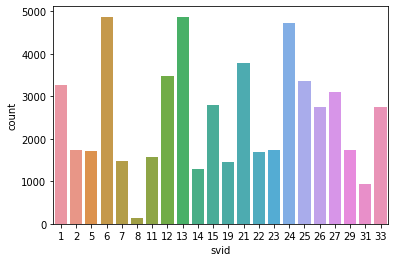

In [206]:
sns.countplot(derived['svid'])

In [207]:
derived.columns

Index(['collectionName', 'phoneName', 'millisSinceGpsEpoch',
       'constellationType', 'svid', 'signalType', 'receivedSvTimeInGpsNanos',
       'xSatPosM', 'ySatPosM', 'zSatPosM', 'xSatVelMps', 'ySatVelMps',
       'zSatVelMps', 'satClkBiasM', 'satClkDriftMps', 'rawPrM', 'rawPrUncM',
       'isrbM', 'ionoDelayM', 'tropoDelayM'],
      dtype='object')

In [208]:
ground.columns

Index(['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg',
       'lngDeg', 'heightAboveWgs84EllipsoidM', 'timeSinceFirstFixSeconds',
       'hDop', 'vDop', 'speedMps', 'courseDegree'],
      dtype='object')

In [214]:
target.columns

Index(['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg_grnd',
       'lngDeg_grnd', 'heightAboveWgs84EllipsoidM_grnd',
       'timeSinceFirstFixSeconds', 'hDop', 'vDop', 'speedMps', 'courseDegree',
       'latDeg_bsln', 'lngDeg_bsln', 'heightAboveWgs84EllipsoidM_bsln',
       'phone', 'latDiff', 'lngDiff'],
      dtype='object')

In [72]:
def plot_sum_on_column(data, group_column, sum_column='latlngDiff'):
    diff_plot_data = target[[sum_column, group_column]].groupby(group_column).sum(sum_column)
    diff_plot_data = diff_plot_data.reset_index()
    plt.figure(figsize=(12,5))
    plt.subplot(121); plt.title(f'{sum_column} vs {group_column}'); 
    plt.scatter(diff_plot_data[group_column], diff_plot_data[sum_column])

In [73]:
plot_diff_columns = ['millisSinceGpsEpoch', 'heightAboveWgs84EllipsoidM_grnd', 'timeSinceFirstFixSeconds', 'hDop', 'vDop', 'speedMps', 'courseDegree', 'heightAboveWgs84EllipsoidM_bsln']
for c in plot_diff_columns:
    plot_sum_on_column(target, c)

NameError: name 'target' is not defined

In [273]:
pd.cut(target['latlngDiff'], 10)

0        (2.6e-05, 5.19e-05]
1       (-2.57e-07, 2.6e-05]
2       (-2.57e-07, 2.6e-05]
3       (-2.57e-07, 2.6e-05]
4       (-2.57e-07, 2.6e-05]
                ...         
1734    (-2.57e-07, 2.6e-05]
1735    (-2.57e-07, 2.6e-05]
1736    (-2.57e-07, 2.6e-05]
1737    (-2.57e-07, 2.6e-05]
1738    (-2.57e-07, 2.6e-05]
Name: latlngDiff, Length: 1739, dtype: category
Categories (10, interval[float64]): [(-2.57e-07, 2.6e-05] < (2.6e-05, 5.19e-05] < (5.19e-05, 7.79e-05] < (7.79e-05, 0.000104] ... (0.000156, 0.000182] < (0.000182, 0.000208] < (0.000208, 0.000234] < (0.000234, 0.00026]]

C:\Users\Shachar Helmer\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='latlngDiff', ylabel='count'>

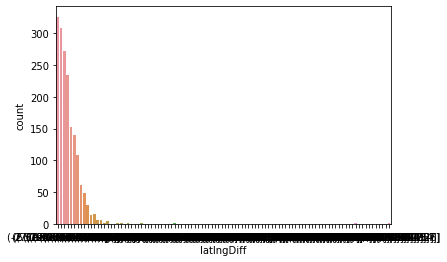

In [275]:
sns.countplot(pd.cut(target['latlngDiff'], 100))

In [23]:
grnd_trn = reduce(lambda x, y: x.merge(y, how='outer'), [pd.read_csv(s)[idx] for s in ground_train_sets])
print(f'Are the ground data samples identical to the baseline sample? {(grnd_trn == bsln_trn[idx]).all().all()}')

NameError: name 'idx' is not defined

In [93]:
def get_keys_not_in_ground(d, g):
    d_df, g_df = pd.read_csv(d), pd.read_csv(g)
    return (d_df.merge(g_df, how='right', indicator=True).query('_merge == "right_only"').groupby(idx).count().shape[0], g_df.shape[0])

[get_keys_not_in_ground(d, g) for d, g in list(zip(derived_train_sets, ground_train_sets))]

[(1, 1740),
 (1746, 1746),
 (2, 1770),
 (316, 577),
 (302, 2031),
 (2, 1965),
 (1794, 1794),
 (1070, 1913),
 (1912, 1912),
 (3, 1926),
 (63, 2003),
 (64, 2006),
 (4, 1713),
 (4, 1707),
 (1770, 1770),
 (1964, 1964),
 (2, 2070),
 (1, 1123),
 (1806, 1806),
 (1755, 1755),
 (41, 1990),
 (1774, 1774),
 (41, 2232),
 (1870, 1870),
 (2, 1246),
 (2, 2095),
 (44, 1742),
 (19, 1975),
 (6, 2009),
 (14, 1744),
 (1791, 1791),
 (27, 1748),
 (57, 1732),
 (861, 1747),
 (1735, 1735),
 (76, 2500),
 (2349, 2349),
 (1259, 1259),
 (1, 2075),
 (1072, 2071),
 (1043, 2071),
 (2076, 2076),
 (1, 1885),
 (906, 1882),
 (918, 1875),
 (1, 1934),
 (1345, 1345),
 (1437, 1437),
 (540, 1431),
 (705, 1427),
 (1199, 1199),
 (1256, 1256),
 (499, 1193),
 (789, 1510),
 (796, 1536),
 (1699, 1699),
 (1, 1718),
 (1, 1739),
 (1046, 1749),
 (4, 2890),
 (1190, 2826),
 (2, 1036),
 (1034, 1034),
 (1999, 1999),
 (1985, 1985),
 (767, 1981),
 (4, 2014),
 (1116, 2083),
 (819, 1602),
 (789, 1596),
 (423, 1659),
 (3, 2330),
 (1226, 2370)]

<h2>Raw Data Analysis</h2>

Each set is part of a collection - an actual route taken at a specific date mentioned in the collection's directory name.</br>
A collection can contain data from multiple mobile devices, each in seperate sub-directory.</br>
Each "collection-mobile device" pair has a 'derived' and ground truth data sets for training.</br>
All derived and ground data sets have the same structure over all collections, both for test and training, as is asserted here:

In [2]:
base_data_dir = 'google-smartphone-decimeter-challenge'

train_collections = [f'{base_data_dir}/train/{collection}' for collection in os.listdir(f'{base_data_dir}/train')]
test_collections = [f'{base_data_dir}/test/{collection}' for collection in os.listdir(f'{base_data_dir}/test')]

print(f'{len(train_collections)} train collections, {len(test_collections)} test collections\n')

derived_train_sets = [f'{c}/{s}/{s}_derived.csv' for c in train_collections for s in os.listdir(c)]
ground_train_sets = [f'{c}/{s}/ground_truth.csv' for c in train_collections for s in os.listdir(c)]
derived_test_sets = [f'{c}/{s}/{s}_derived.csv' for c in test_collections for s in os.listdir(c)]


drvd_trn_clms = reduce(lambda s1, s2: s1.union(s2), [set(list(pd.read_csv(s, nrows=1).columns)) for s in derived_train_sets])
grnd_trn_clms = reduce(lambda s1, s2: s1.union(s2), [set(list(pd.read_csv(s, nrows=1).columns)) for s in ground_train_sets])
drvd_tst_clms = reduce(lambda s1, s2: s1.union(s2), [set(list(pd.read_csv(s, nrows=1).columns)) for s in derived_test_sets])
print('Do all columns appear in all the data sets?')
print(f'Derived train data: {drvd_trn_clms == set(list(pd.read_csv(derived_train_sets[0], nrows=1).columns))}')
print(f'Ground truth train data: {grnd_trn_clms == set(list(pd.read_csv(ground_train_sets[0], nrows=1).columns))}')
print(f'Derived test data: {drvd_tst_clms == set(list(pd.read_csv(derived_test_sets[0], nrows=1).columns))}')

29 train collections, 19 test collections

Do all columns appear in all the data sets?
Derived train data: True
Ground truth train data: True
Derived test data: True


The mobile device type distribution over test and train collections is identical as is aserted and displayed:

The derived data set contains samples uniquely defined by:
- The device type (phoneName)
- The collection it is (at which session was it sampled)
- the time the sample was taken at in milliseconds passed since the GPS epoch.

Each such unique sample has a varying amount of satelite samples describing it - rows in the derived data set, yet they all refer to the same time-location combination.</br>
In the ground truth data set, samples are matched with rows in an "on" and "one-to-one" fashion. 

In [52]:
idx = ['phoneName', 'collectionName', 'millisSinceGpsEpoch']
sample_data_size = pd.read_csv(derived_train_sets[0]).groupby(idx).size()
#print(sample_data_size)
aggs = sample_data_size.agg(["mean", "count", "min", "max"])
mean, count, _min, _max = aggs[0], aggs[1], aggs[2], aggs[3]
print(f'avg number of derived data points per sample is: {mean}')
print(f'max number of data points per sample: {_max}')
print(f'min number of data points per sample: {_min}')
print(f'number of unique samples: {int(count)}')
# plot this distribution? over time on the y-axis? over location on a map? with a heat map?

avg number of derived data points per sample is: 31.752731454859113
max number of data points per sample: 62.0
min number of data points per sample: 6.0
number of unique samples: 1739


In [11]:
derived_train_sizes = [pd.read_csv(s).shape[0] for s in derived_train_sets]
ground_train_sizes = [pd.read_csv(s).shape[0] for s in ground_train_sets]
derived_train_t_size = reduce(lambda x, y: x + y, derived_train_sizes)
ground_train_t_size = reduce(lambda x, y: x + y, ground_train_sizes)
print(f'# of training samples: {ground_train_size}, with {derived_train_size} matching derived data points')
fig, ax = plt.subplots()
ax.pie(derived_train_sizes, labels=[s.split('_')[0].split('train')[1] for s in derived_train_sets], labeldistance=1.3)
plt.show()

<h2>Features</h2>

Each derived data set contains various GNSS measurements. 

**collectionName** - The "parent" folder, in which drive was this sampled.

**phoneName** - Celluler device used for this sample.

**millisSinceGpsEpoch** - An integer number of milliseconds since the GPS epoch (1980/1/6 midnight UTC).

**constellationType**: GNSS constellation type. An integer number, whose mapping string value is provided in constellation_type_mapping.csv.

**svid** - The satellite ID.

**signalType** - The GNSS signal type is a combination of the constellation name and the frequency band. Common signal types measured by smartphones include: GPS_L1, GPS_L5, GAL_E1, GAL_E5A, GLO_G1, BDS_B1I, BDS_B1C, BDS_B2A, QZS_J1, and QZS_J5.

**receivedSvTimeInGpsNanos** - The signal transmission time received by the chipset, in the numbers of nanoseconds since the GPS epoch. Converted from ReceivedSvTimeNanos, this derived value is in a unified time scale for all constellations, while ReceivedSvTimeNanos refers to the time of day for GLONASS and the time of week for non-GLONASS constellations.

**[x/y/z]SatPosM** - The satellite position (meters) in an ECEF coordinate frame at best estimate of “true signal transmission time” defined as ttx = receivedSvTimeInGpsNanos - satClkBiasNanos (defined below). They are computed with the satellite broadcast ephemeris, and have ~1-meter error with respect to the true satellite position.

**[x/y/z]SatVelMps** - The satellite velocity (meters per second) in an ECEF coordinate frame at the signal transmission time (receivedSvTimeInGpsNanos). They are computed with the satellite broadcast ephemeris, with this algorithm.

**satClkBiasM** - The satellite time correction combined with hardware delay in meters at the signal transmission time (receivedSvTimeInGpsNanos). Its time equivalent is termed as satClkBiasNanos.

satClkBiasNanos equals the satelliteTimeCorrection minus the satelliteHardwareDelay.
As defined in IS-GPS-200H Section 20.3.3.3.3.1, satelliteTimeCorrection is calculated from ∆tsv = af0 + af1(t - toc) + af2(t - toc)2 + ∆tr, while satelliteHardwareDelay is a term defined in Section 20.3.3.3.3.2.
Parameters in equations above are provided on the satellite broadcast ephemeris.
satClkDriftMps - The satellite clock drift in meters per second at the signal transmission time (receivedSvTimeInGpsNanos). It equals the difference of the satellite clock biases at t+0.5s and t-0.5s.

**rawPrM** - Raw pseudorange in meters. It is the product between the speed of light and the time difference from the signal transmission time (receivedSvTimeInGpsNanos) to the signal arrival time (Raw::TimeNanos - Raw::FullBiasNanos - Raw::BiasNanos).

**rawPrUncM** - Raw pseudorange uncertainty in meters. It is the product between the speed of light and the ReceivedSvTimeUncertaintyNanos.

**isrbM** - The Inter-Signal Range Bias (ISRB) in meters from a non-GPS-L1 signal to GPS-L1 signals. For example, when the isrbM of GPS L5 is 1000m, it implies that a GPS L5 pseudorange is 1000m longer than the GPS L1 pseudorange transmitted by the same GPS satellite. It's zero for GPS-L1 signals. ISRB is introduced in the GPS chipset level and estimated as a state in the Weighted Least Squares engine.
**
**ionoDelayM** - The ionospheric delay in meters, estimated with the Klobuchar model.

**tropoDelayM** - The tropospheric delay in meters, estimated with the EGNOS model by Nigel Penna, Alan Dodson and W. Chen (2001).

**NEEDS SIMPLYFING AND FURTHER EXPLAINING**

<h2>Feature Values</h2>
<h3>Distribution</h3>

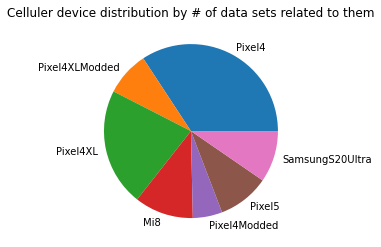

Is the device distribution equal over the train and test data? True


In [21]:
phone_trn_count = Counter([s.split('/')[-2] for s in derived_train_sets])
phone_grnd_count = Counter([s.split('/')[-2] for s in ground_train_sets])
fig, ax = plt.subplots()
ax.pie([v for v in phone_trn_count.values()], labels=[k for k in phone_trn_count.keys()])
ax.title.set_text('Celluler device distribution by # of data sets related to them')
plt.show()
print(f'Is the device distribution equal over the train and test data? {phone_trn_count == phone_grnd_count}')

In [32]:
d_df = pd.read_csv(derived_train_sets[0]) # read and concatenate all derived data?..
d_df.columns

Index(['collectionName', 'phoneName', 'millisSinceGpsEpoch',
       'constellationType', 'svid', 'signalType', 'receivedSvTimeInGpsNanos',
       'xSatPosM', 'ySatPosM', 'zSatPosM', 'xSatVelMps', 'ySatVelMps',
       'zSatVelMps', 'satClkBiasM', 'satClkDriftMps', 'rawPrM', 'rawPrUncM',
       'isrbM', 'ionoDelayM', 'tropoDelayM'],
      dtype='object')

In [34]:
d_df_sat_pos = d_df[['xSatPosM', 'ySatPosM', 'zSatPosM']]
d_df_sat_speed = d_df[['xSatVelMps', 'ySatVelMps', 'zSatVelMps']]
d_df_delay = d_df[['ionoDelayM', 'tropoDelayM']]
# plot constellation types
# plot signal types
# understand if all derived samples (key samples contain each of which signals and constellations)

<AxesSubplot:xlabel='variable', ylabel='value'>

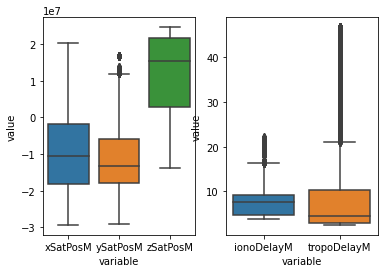

In [35]:
fig, axs = plt.subplots(1, 2)
sns.boxplot(x='variable', y='value', data=pd.melt(d_df_sat), ax = axs[0])
sns.boxplot(x='variable', y='value', data=pd.melt(d_df_delay), ax = axs[1])